In [1]:
import cv2 as cv
from google.colab.patches import cv2_imshow as show
import os
from google.colab import drive
import numpy as np
from multiprocessing.pool import ThreadPool
drive.mount('/content/gdrive/', force_remount=True) 

Mounted at /content/gdrive/


In [2]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.0 MB/s 


In [3]:
%load_ext autotime

time: 419 µs (started: 2023-01-01 18:25:09 +00:00)


In [4]:
path="/content/gdrive/My Drive/Colab Notebooks/AIN432_ass4/dataset"

time: 613 µs (started: 2023-01-01 18:25:09 +00:00)


In [98]:
template=dict()

time: 627 µs (started: 2023-01-01 20:02:48 +00:00)


In [99]:
for i in os.listdir(path+"/template"):
  img = cv.imread(path+"/template/"+i,0)
  img_blr=cv.GaussianBlur(img, (15, 15), 0)
  label=i[0]
  template[label]=np.array(img)

time: 5.43 s (started: 2023-01-01 20:02:50 +00:00)


In [176]:
import cv2
from google.colab.patches import cv2_imshow as show
import matplotlib.pyplot as plt


time: 910 µs (started: 2023-01-01 20:47:57 +00:00)


In [188]:
# Own normalized cross correlation method
def cross_correlation(target_img,temp_img_data):
  img=target_img.copy()
  # label --> most similar temp , score --> similarity score (-1, 1), x_,y_ --> which part ( x and y axis ) of the target image most similar template image
  results=dict()
  # This loop change the template img whic compare the target image
  for temp_img in temp_img_data:
    result=[]
    temp_image=temp_img_data[temp_img]
    # This twice for loop change the x and y axis
    for i in range(len(target_img)-len(temp_img_data[temp_img])+1):
      temp=[]
      for j in range(target_img.shape[1]-temp_img_data[temp_img].shape[1]+1):
        #seperate images which compare each other
        target_image=target_img[i:len(temp_img_data[temp_img])+i,j:temp_img_data[temp_img].shape[1]+j]
        # apply normalized cross correlation  formula template and target image  
        numerator=np.sum(np.multiply(np.subtract(temp_image,np.mean(temp_image)),np.subtract(target_image,np.mean(target_image))))
        denumerator=np.sqrt(np.multiply(np.sum(np.square(np.subtract(temp_image,np.mean(temp_image)))),np.sum(np.square(np.subtract(target_image,np.mean(target_image))))))
        temp.append(numerator/denumerator)
      result.append(temp)
    result=np.array(result)
    y, x = np.unravel_index(np.argmax(result), result.shape)
    top_right=[x,y]
    down_left=[x+temp_image.shape[1],y+temp_image.shape[0]]
    results[temp_img]=(result[y][x],top_right,down_left)
    """if score==None or score<result[y][x]:
      label=temp_img
      score=result[y][x]
      x_=x
      y_=y"""
  return results

time: 3.56 ms (started: 2023-01-01 20:53:10 +00:00)


In [187]:
def choose_label(errors,label=0):
  sorted_errors = sorted(errors.items(), key=lambda x:x[1][0],reverse=True)
  if label==0:
    max_label=sorted_errors[0][0]
    return errors[max_label],max_label
  return errors[label],label


time: 1.38 ms (started: 2023-01-01 20:53:09 +00:00)


In [173]:
# We can also compute normalize cross correlation using cv2 library
def cross_correlation_using_cv2(target_img,temp_img_data):
  img=target_img.copy()
  results=dict()
  for temp_img in temp_img_data:
    result=[]
    temp_image=temp_img_data[temp_img]
    result= cv2.matchTemplate(target_img,temp_image, cv.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc= cv2.minMaxLoc(result)
    y, x = np.unravel_index(np.argmax(result), result.shape)
    top_right=[x,y]
    down_left=[x+temp_image.shape[1],y+temp_image.shape[0]]
    results[temp_img]=(result[y][x],top_right,down_left)
  return results

time: 2.25 ms (started: 2023-01-01 20:47:43 +00:00)


In [174]:
def plot_imgs(target_img,target_img_name,temp_img,temp_img_name,match_img,):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 4))
    ax1.imshow(target_img, cmap='gray');
    ax2.imshow(temp_img, cmap='gray');
    ax3.imshow(match_img, cmap='gray');
    ax1.title.set_text("Target '{}'".format(target_img_name))
    ax2.title.set_text("Template '{}'".format(temp_img_name))
    ax3.title.set_text("Matching Region")

time: 1.87 ms (started: 2023-01-01 20:47:44 +00:00)


In [ ]:
img = cv.imread(path+"/target/B/B1.jpg",0)

time: 1.84 s (started: 2023-01-01 16:02:23 +00:00)


In [ ]:
results=cross_correlation(img,template)

time: 9.39 s (started: 2023-01-01 16:02:25 +00:00)


In [ ]:
for label in template:
  (score,top_left,bottom_right),label=choose_label(results,label)
  rect_img=cv2.rectangle(img.copy(), top_left, bottom_right, (0,0,255),1)
  font = cv2.FONT_HERSHEY_SIMPLEX
  cv2.putText(img=rect_img, text=str(round(score,2)), org=(img.shape[0]-50,img.shape[1]-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.6, color=(0, 255, 0),thickness=1);
  plot_imgs(img,"B",template[label],label,rect_img)


All data train time = 2 hour 4 min

In [ ]:
y_pred=[]
y_test=[]
for i in os.listdir(path+"/target"):
  for j in os.listdir(path+"/target/"+i):
    img = cv.imread(path+"/target/"+i+"/"+j,0)
    label=choose_label(cross_correlation(img,template))[1]
    y_pred.append(label)
    y_test.append(i)

In [177]:
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.svm import SVC
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import pandas as pd

time: 1.14 ms (started: 2023-01-01 20:48:07 +00:00)


In [29]:
acc= accuracy_score(y_test,y_pred)
print(acc)

0.11282051282051282
time: 2.96 ms (started: 2023-01-01 18:31:22 +00:00)


In [165]:
column_name=sorted(list(template.keys()))

time: 7.43 ms (started: 2023-01-01 20:33:57 +00:00)


In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm

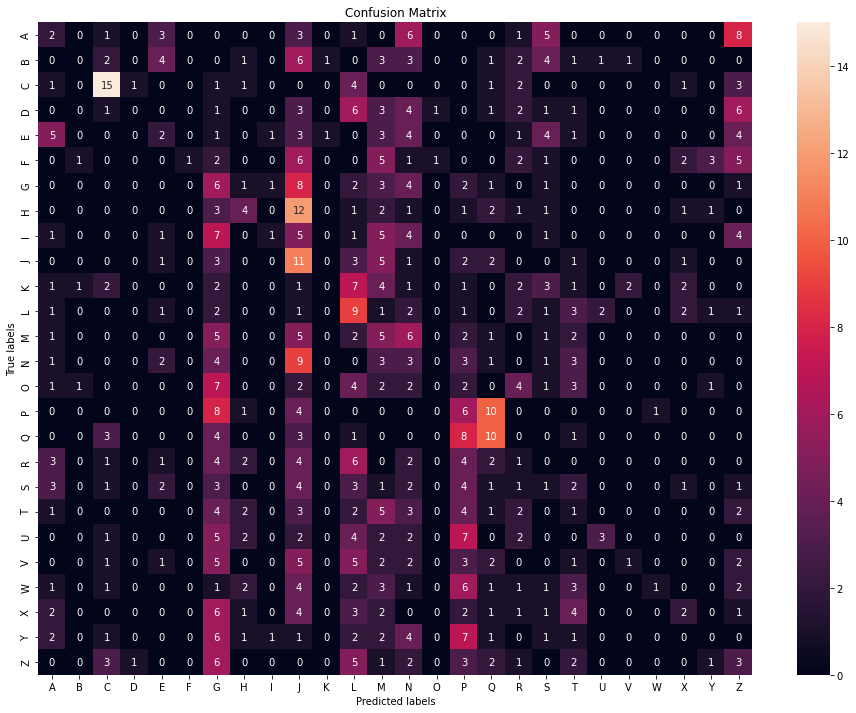

time: 2.17 s (started: 2023-01-01 20:34:27 +00:00)


In [167]:
# Confusion Matrix
f = plt.figure(figsize=(16,12))
ax = f.add_subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(column_name); 
ax.yaxis.set_ticklabels(column_name);

In [225]:
k=dict()
for i in range(len(y_test)):
  if y_test.iloc[i][0] == y_pred.iloc[i][0]:
    k[ y_test.iloc[i][0]]=i

time: 118 ms (started: 2023-01-01 21:22:08 +00:00)


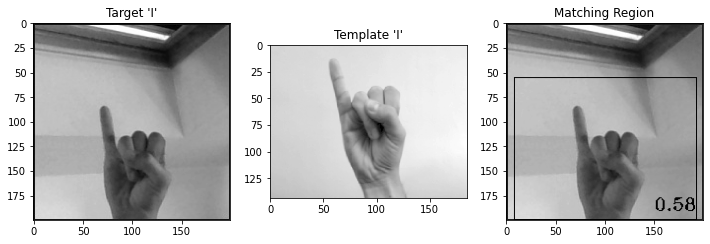

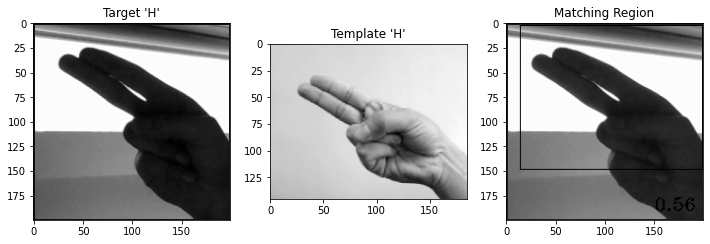

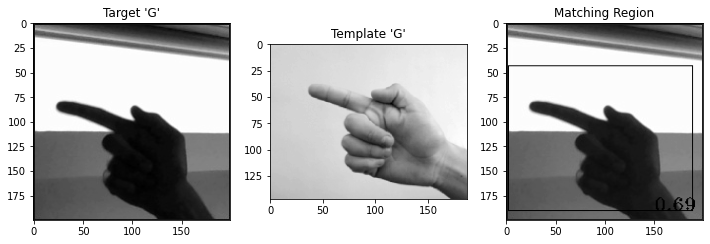

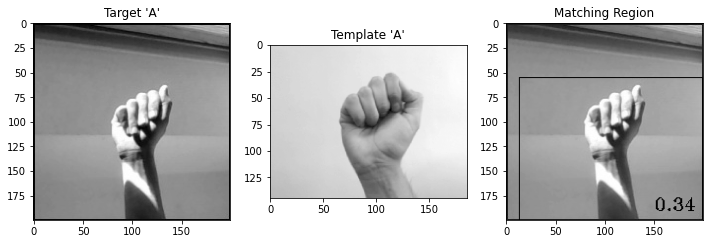

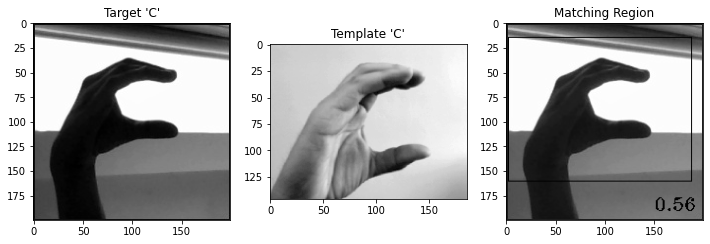

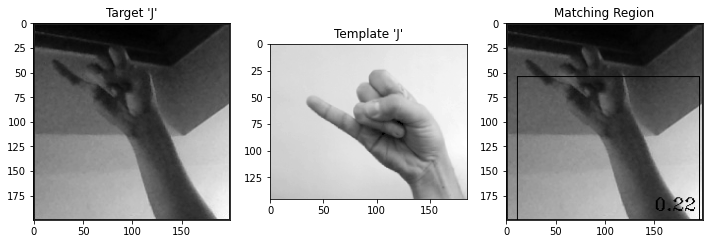

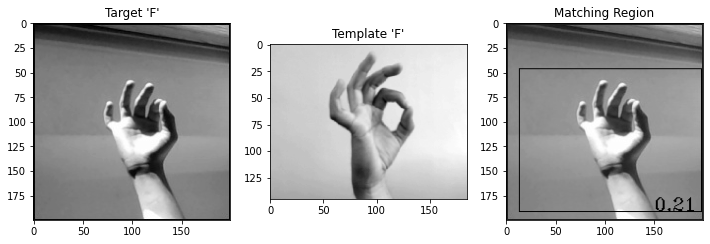

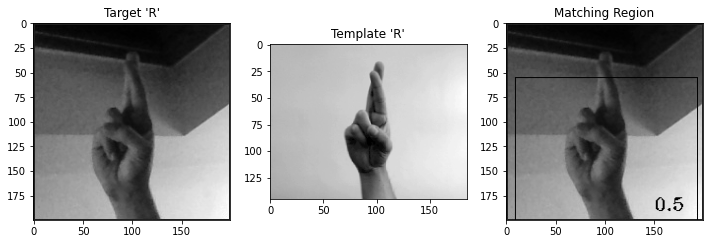

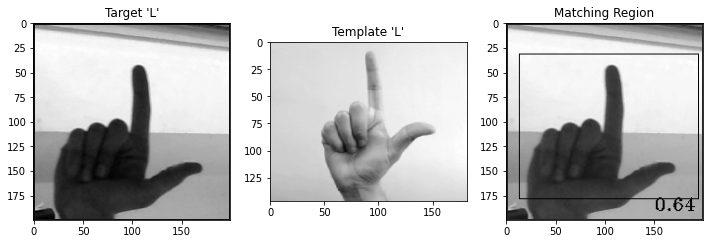

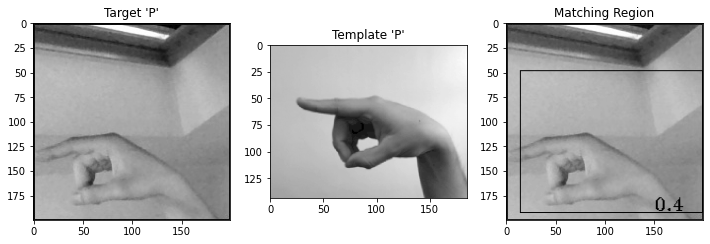

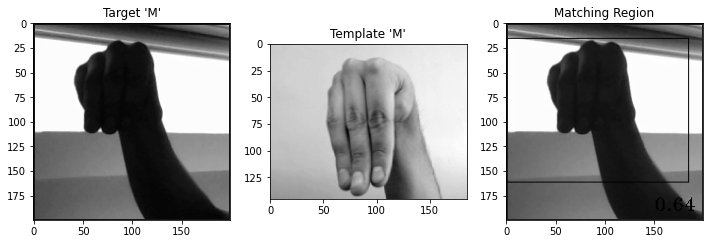

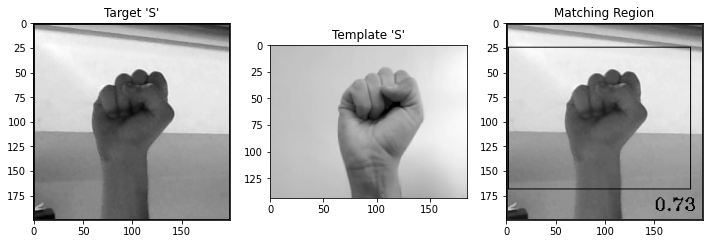

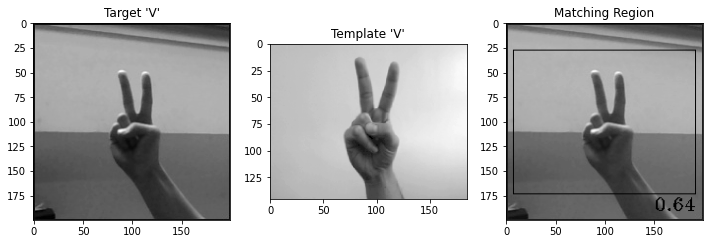

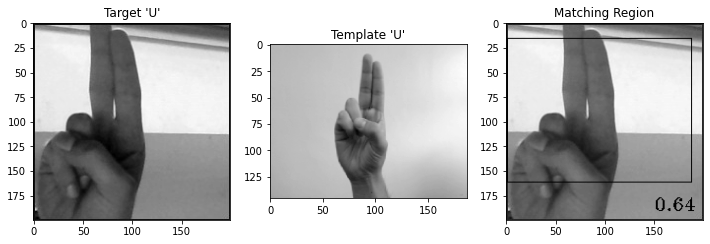

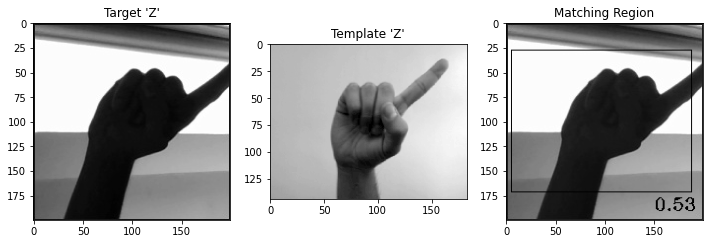

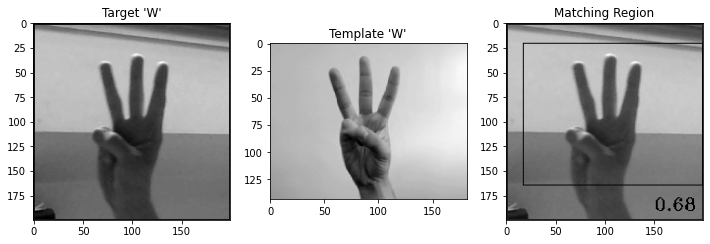

time: 3min 23s (started: 2023-01-01 21:13:10 +00:00)


In [224]:
# Matched examples
for i in os.listdir(path+"/target"):
  if i in k:
    j=os.listdir(path+"/target/"+i)[k[i]%30]
    img = cv.imread(path+"/target/"+i+"/"+j,0)
    results=cross_correlation(img,template)
    (score,top_left,bottom_right),label=choose_label(results)
    if label==i:
      rect_img=cv2.rectangle(img.copy(), top_left, bottom_right, (0,0,255),1)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img=rect_img, text=str(round(score,2)), org=(img.shape[0]-50,img.shape[1]-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.6, color=(0, 255, 0),thickness=1);
      plot_imgs(img,i,template[label],label,rect_img)


In [ ]:
k=dict()
for i in range(len(y_test)):
  if y_test.iloc[i][0] != y_pred.iloc[i][0]:
    k[ y_test.iloc[i][0]]=i

In [228]:
# Unmatched examples
for i in os.listdir(path+"/target"):
  if i in k:
    j=os.listdir(path+"/target/"+i)[k[i]%30]
    img = cv.imread(path+"/target/"+i+"/"+j,0)
    results=cross_correlation(img,template)
    (score,top_left,bottom_right),label=choose_label(results)
    rect_img=cv2.rectangle(img.copy(), top_left, bottom_right, (0,0,255),1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img=rect_img, text=str(round(score,2)), org=(img.shape[0]-50,img.shape[1]-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.6, color=(0, 255, 0),thickness=1);
    plot_imgs(img,i,template[label],label,rect_img)

Output hidden; open in https://colab.research.google.com to view.